# Predicting possible credit defaulters using data from a financial institution

In [1]:
import warnings
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import sys
import os
import kagglehub

## Table of contents:
1. [Introduction](#introduction)
2. [Preparation of the data](#preparation)
3. [Modeling of the data](#modeling)
4. [Permutation feature importance](#importances)

## 1. Introduction <a class="anchor" id="introduction"></a>

The dataset comprises the credit history of the customers from a financial institution [1]. The objective is to predict for possible credit defaulters upfront and help the financial institutions to take steps accordingly.



## 2. Preparation of the data <a class="anchor" id="preparation"></a>

### 2.1. Size of the dataset

In [2]:
# warnings.filterwarnings('ignore') # Ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
# Download latest version of the data from Kaggle and save the local path in
# which it is stored:
path = kagglehub.dataset_download("ranadeep/credit-risk-dataset")

In [4]:
dataset = pd.read_csv(f"{path}/loan/loan.csv")
pd.set_option('display.max_columns', None) # Show all columns in the DataFrame
dataset.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset contains 887379 IDs corresponding to different individuals, and each person is described by 74 features.

The description of each feature can be consulted in the file ``LCDataDictionary.xlsx``.

In [5]:
print(f'Number of tuples: {dataset.shape[0]}')
print(f'Number of attributes: {dataset.shape[1]}')
print(f'Number of unique individuals: {len(dataset.id.unique())}')

Number of tuples: 887379
Number of attributes: 74
Number of unique individuals: 887379


### 2.2. Stratified sample

In order to reduce computing times, it is better to consider only 10% of tuples from each category in the target column ``loan_status``:

In [6]:
# Take 10% of the tuples from each category in LOAN_STATUS:
dataset = dataset.groupby('loan_status', group_keys = False).apply(lambda x: x.sample(frac = 0.1))

### 2.2. Target attribute

In [7]:
dataset.loan_status.unique()

array(['Charged Off', 'Current', 'Default',
       'Does not meet the credit policy. Status:Charged Off',
       'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid',
       'In Grace Period', 'Issued', 'Late (16-30 days)',
       'Late (31-120 days)'], dtype=object)

The target attribute will be ``loan_status``, as the idea is to identify which features have the most importance to determine if a credit will probably default.

Also, ``id`` and ``member_id`` columns are discarded due to their irrelevance.

In [8]:
Y = dataset.loan_status # Target
X = dataset.drop(columns = ['id', 'member_id', 'loan_status']) # Features

- If ``loan_status`` has values 'Default', 'Charged Off' or 'Does not meet the credit policy. Status:Charged Off', it will be considered **bad credit** (``loan_status = 0``)
- Otherwise, it will be considered **good credit** (``loan_status = 1``)

In [9]:
Y = Y.apply(lambda x: 0 if x == 'Default'
            or x == 'Charged Off'
            or x == 'Does not meet the credit policy. Status:Charged Off'
            else 1)

Now, the proportion of the two new classes would be:

In [10]:
Y.value_counts()[0] / Y.value_counts()[1] * 100

5.62161518776409

<Axes: xlabel='loan_status'>

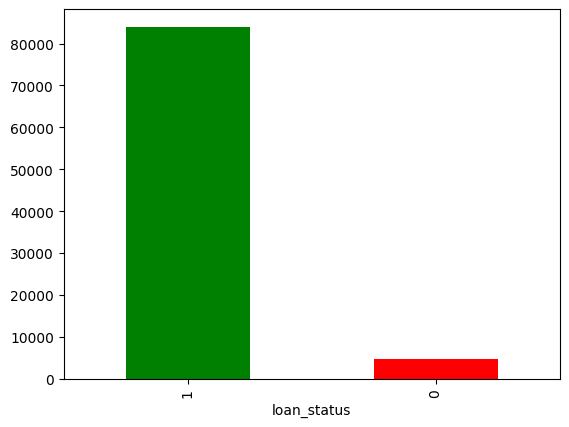

In [11]:
Y.value_counts().plot.bar(color = ['green', 'red'])

The two classes are imbalanced: there are only $\sim 5.62\%$ instances of **bad credit** in the dataset. This difference is consistent with what would be expected.

It remains to see if, while modeling, a weighted model (that accounts for the imbalances in both classes) is better than a uniform model.

### 2.3. Data types of the predictive features

There are 2 features with integer values, 49 with float values and 22 objects. Let's analyze the objects.

In [12]:
X.dtypes.value_counts()

float64    49
object     22
Name: count, dtype: int64

Float columns can be scaled to reduce computing time when fitting a model to the data:

In [13]:
# Columns with float64 data type:
numeric_columns = X.select_dtypes(include = ['float64']).columns

# Min-max scaler:
scaler = MinMaxScaler()

X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [14]:
X.select_dtypes(include = ['object']).head(5)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint
354165,60 months,F,F3,Network Infrastructure Support Tech,10+ years,MORTGAGE,Verified,Jul-2014,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,330xx,FL,May-1999,f,May-2015,NaN,Jan-2016,INDIVIDUAL,NaN
159289,36 months,D,D3,SAP/Sybase,10+ years,RENT,Source Verified,Mar-2013,n,https://www.lendingclub.com/browse/loanDetail....,NaN,other,Taxes and Loan Payoff,254xx,WV,Dec-1972,f,Aug-2014,NaN,Jan-2016,INDIVIDUAL,NaN
24804,36 months,A,A4,WOW,< 1 year,RENT,Verified,Oct-2010,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Surgery Loan,077xx,NJ,Sep-2000,f,Oct-2012,NaN,Jan-2016,INDIVIDUAL,NaN
184578,36 months,C,C4,NaN,NaN,RENT,Verified,Nov-2012,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 11/16/12 > In between jobs...,other,Hold me over until I start my new job,900xx,CA,Oct-2002,w,Jan-2014,NaN,May-2014,INDIVIDUAL,NaN
27960,60 months,E,E5,Wylie ISD,1 year,MORTGAGE,Verified,Jul-2010,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Todd's Loan,750xx,TX,Nov-1995,f,Sep-2014,NaN,Jan-2015,INDIVIDUAL,NaN


The attribute ``term`` only contains two values: 36 and 60 months:

In [15]:
X.term.unique()

array([' 60 months', ' 36 months'], dtype=object)

 Therefore:
 1. ``term`` can be converted to an integer corresponding to the number of months
 2. ``url`` and ``desc`` can be dropped
 3. The other columns can be one-hot encoded

In [16]:
# Convert the TERM column to integer type:
X.loc[X['term'] == ' 36 months', 'term'] = 36
X.loc[X['term'] == ' 60 months', 'term'] = 60
X["term"] = pd.to_numeric(X["term"])

# Drop URL and DESC columns:
X.drop(columns = ['url', 'desc'], inplace = True)

In [17]:
# Select the columns with datatype OBJECT:
categorical_columns = X.select_dtypes(include = ['object']).columns

# Label encode the categorical columns:
encoder = LabelEncoder()

for column in categorical_columns:
    X[column] = encoder.fit_transform(X[column])

### 2.4. Replace NaN values with median

There are no NaN values in the target column:

In [18]:
Y.isna().sum() 

0

But there are in the other features. The solution is to fill NaN values with the median of the corresponding column:

In [19]:
X = X.fillna(X.median())

## 3. Modeling of the data <a class="anchor" id="modeling"></a>

Comparison of three models of the data (Logistic Regression, Support Vector Machines and Random Forest) with and without weights (to account for imbalances).

### 3.1. Error metrics

In [20]:
def show_metrics(y_true: list, y_pred: list) -> None:
    """
    Show Accuracy, Precision, Recall and F1 scores.
    - Y_TRUE: true target labels
    - Y_PRED: predicted target labels
    """
    print(f'- Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'- Precision: {precision_score(y_true, y_pred)}')
    print(f'- Recall: {recall_score(y_true, y_pred)}')
    print(f'- F1: {f1_score(y_true, y_pred)}')

### 3.2. Grid Search

In [21]:
def grid_search(model,
                parameters: list,
                X_train: pd.DataFrame,
                Y_train: pd.Series,
                X_test: pd.DataFrame,
                Y_test: pd.Series,
                cv: int = 2) -> GridSearchCV:
    """
    Perform Grid Search of the PARAMETERS of a certain MODEL, with
    cross-validation parameter CV.
    Return the GridSearchCV object after fitting.
    """
    # Grid Search on training data:
    classifier = GridSearchCV(model, parameters, cv = cv, n_jobs = -1) 
    classifier.fit(X_train, Y_train)
    print(f'- Best parameters: {classifier.best_params_}')

    # Predict values:
    y_pred = classifier.predict(X_test)

    # Show error metrics:
    show_metrics(y_true = Y_test, y_pred = y_pred)

    return classifier

### 3.3. Train and test splits

The dataset will be separated in 70% train and 30% test samples:

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.3,
                                                    random_state = 1)

### 3.4. Logistic Regression

In [23]:
# Logistic Regression model:
lr_model = LogisticRegression(n_jobs = -1, solver = 'saga', max_iter = 100)
lr_parameters = {'penalty': ['l1', 'l2'],
                 'class_weight': [None, 'balanced']}

lr_classifier = grid_search(lr_model, lr_parameters,
                    X_train, Y_train, X_test, Y_test)

- Best parameters: {'class_weight': None, 'penalty': 'l1'}
- Accuracy: 0.946773345353467
- Precision: 0.946773345353467
- Recall: 1.0
- F1: 0.9726590387249889


A Grid Search determines that the best model of **Logistic Regression** uses L1 regularization and no class weights, achieving good performance.

### 3.5. Linear Support Vector

In [24]:
# LSV model:
lsv_model = LinearSVC(max_iter = 100)
lsv_parameters = {'class_weight': [None, 'balanced'],
                  'C': [0.01, 0.1, 1.0],
                  'penalty': ['l1', 'l2']}

lsv_classifier = grid_search(lsv_model, lsv_parameters,
                    X_train, Y_train, X_test, Y_test)

- Best parameters: {'C': 1.0, 'class_weight': None, 'penalty': 'l1'}
- Accuracy: 0.9961685823754789
- Precision: 0.9960871111813763
- Recall: 0.999880975996826
- F1: 0.9979804379677663


For the **Linear Support Vector** model, the best parameters are $C=1.0$, no class weights and L1 penalty.

### 3.6. Random Forest

In [25]:
# Random Forest model:
rf_model = RandomForestClassifier(n_jobs = -1, criterion = 'gini', max_depth = 5)
rf_parameters = {'n_estimators': [50, 100],
                 'class_weight': [None, 'balanced']}

rf_classifier = grid_search(rf_model, rf_parameters,
                X_train, Y_train, X_test, Y_test)

- Best parameters: {'class_weight': None, 'n_estimators': 100}
- Accuracy: 0.9802043422733078
- Precision: 0.9795196642313073
- Recall: 1.0
- F1: 0.9896538861731158


For the **Random Forest** model, the best parameters are: no class weights and 50 trees.

## 4. Permutation feature importance <a class="anchor" id="importances"></a>

As the **Linear Support Vector** model has the best F1 score, it appears to be the best model.

In [26]:
def plot_feature_importances(perm_importance_result, feat_name):
    """bar plot the feature importance"""

    fig, ax = plt.subplots()

    indices = perm_importance_result["importances_mean"].argsort()[-10:]
    plt.barh(
        range(len(indices)),
        perm_importance_result["importances_mean"][indices],
        xerr=perm_importance_result["importances_std"][indices]
    )

    ax.set_title("Permutation Importances (train set)")
    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

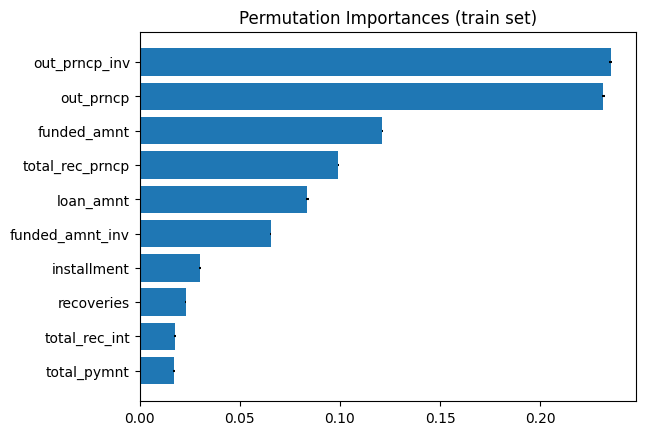

In [27]:
# List of importances obtained via the Permutation Feature Importance method:
perm_importance = permutation_importance(lsv_classifier.best_estimator_, X_train, Y_train)

plot_feature_importances(perm_importance, X_train.columns)

Thus, the five most important features in determining if a bank credit will **default** (``loan_status``) are:

1. ``out_prncp_inv``: "Remaining outstanding principal for portion of total amount funded by investors"
2. ``out_prncp``: "Remaining outstanding principal for total amount funded"
3. ``funded_amnt``: "The total amount committed to that loan at that point in time"
4. ``total_rec_prncp``: "Principal received to date"
5. ``loan_amnt``: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value"

As **next steps**, it would be interesting to perform the same analysis with the whole sample, although the computing time it would take would increase significantly.

# References

[1] R.G. (2021). Credit Risk Analysis [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/2327131